In [1]:
import pandas as pd
import numpy as np
from Optimised_code_upgraded import main
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import os
sns.set_theme()

In [2]:
tba = 'FNCL'
model = 'DATA_SAMY'

TBAS_PRICES = pd.read_csv(f"e://ehz/data/mbs/{tba}/mbs.csv", index_col=0, parse_dates=True).dropna(how="all")

if tba =='FNCL' :
    d1 = pd.to_datetime('01/22/2021')
    TBAS_PRICES.loc[: d1, f'{tba} 2.0 N Mtge'] = np.nan

    d1 = pd.to_datetime('06/12/2012')
    d2 = pd.to_datetime('02/11/2020')
    TBAS_PRICES.loc[d1:d2, f'{tba} 7.0 N Mtge'] = np.nan
    TBAS_PRICES.to_csv(f"Data/{tba}/GENERIC_TBAS.csv")

else :
    d1 = pd.to_datetime('06/12/2012')
    d2 = pd.to_datetime('01/01/2023')
    TBAS_PRICES.loc[d1:d2, f'{tba} 7.0 N Mtge'] = np.nan

TBAS_PRICES.to_csv(f"Data/{tba}/GENERIC_TBAS.csv")
TBAS_PRICES.columns = TBAS_PRICES.columns.map(lambda x: float(x.split()[1]))
TBAS_PRICES = TBAS_PRICES.loc[:, 2:7]
TBAS_PRICES.columns = TBAS_PRICES.columns.map(lambda x: f'FNCL {x} N Price')

OAS_BLOOM = pd.read_csv(f"e://ehz/data/mbs/{tba}/mbs_oas.csv", index_col=0, parse_dates=True)
OAS_BLOOM.columns = OAS_BLOOM.columns.map(lambda x: float(x.split(' ')[0][-4:-1])/10)
ALL_CPNS = np.arange(2, 7.5, 0.5)
OAS_BLOOM = OAS_BLOOM[ALL_CPNS]
OAS_BLOOM.to_csv(f"Data/{tba}/OAS_vs_TREAS.csv")
OAS_BLOOM = OAS_BLOOM.loc[:, 2:7]
OAS_BLOOM.columns = OAS_BLOOM.columns.map(lambda x: f'FNCL {x} N OAS')
OAS_BLOOM.loc[TBAS_PRICES.index[0]: TBAS_PRICES.index[-1]]


mtg_rate_daily = pd.read_csv(f'E:/ehz/data/mbs/{tba}/mtg_rate.csv', index_col=0, parse_dates=True).iloc[:,0]


vols = pd.read_csv('E:/ehz/data/vol/swaptions_vols.csv', index_col=0, parse_dates=True)
vols = vols.map(lambda x: float(x.replace(',', '.'))).sort_index()
vol = vols['3M10Y'].loc[TBAS_PRICES.index[0]: TBAS_PRICES.index[-1]]/100
vol.name = 'Volatility'

mtg_rate_for_data = mtg_rate_daily.loc[TBAS_PRICES.index[0]: TBAS_PRICES.index[-1]].copy()
mtg_rate_for_data.name = 'Mortgage Rate'

unused = pd.DataFrame(index = TBAS_PRICES.index, columns = ['Coupon effectif', 'Coupon TBA'], dtype=float)

loan_age = pd.DataFrame(index=TBAS_PRICES.index, columns=np.arange(2, 7.5, 0.5), data=0)
loan_age.columns = [f'FNCL {c} N Loan Age ' for c in np.arange(2, 7.5, 0.5) ]
loan_age = loan_age.loc[TBAS_PRICES.index]

zc = pd.read_csv('E:/ehz/data/US_TREAS_CURVE/OTR/discount_factors.csv',index_col=0, parse_dates=True)
zc.columns = zc.columns.map(int)

zc = zc.loc[TBAS_PRICES.loc[:zc.index.max()].index, np.arange(30,11311,30)]
rates = (-np.log(zc)).divide(zc.columns/360)
rates = rates.ffill(axis=1)
zc_interpolated = np.exp(-rates.multiply(zc.columns/360))
zc_interpolated.columns = [f'zc_{x}d' for x in zc.columns]

In [3]:
folder = f'{tba}/{model}'
if not os.path.isdir(f'Data/{folder}') : 
    os.mkdir(f'Data/{folder}')


new_data = pd.concat((
    TBAS_PRICES,
    OAS_BLOOM,
    vol,
    mtg_rate_for_data,
    unused,
    loan_age,
    zc_interpolated
), axis=1)
new_data = new_data.loc[TBAS_PRICES.index]


new_data['Volatility'] = new_data['Volatility'].bfill(axis=0).ffill(axis=0)
new_data['Mortgage Rate'] = new_data['Mortgage Rate'].bfill(axis=0).ffill(axis=0)
new_data[zc_interpolated.columns] = new_data[zc_interpolated.columns].bfill(axis=0).ffill(axis=0)
#
new_data.index.name = 'Dates'
new_data.to_csv(f'Data/{folder}/mbs_global_data_cleaned_final_2010_2024.csv')

In [6]:
params = {
       'bmin': 0.05,
       'bmax': 0.05,
       'spreadmin': 0.30,
       'spreadmax': 0.30,
       'alpha': 150,
       'gamma': 0.05,
       'vol_multiplier': 1.4
}

main(folder, params=params)

df = pd.read_csv(f'Data/{folder}/oas_result_global_2010_2024_with_pnl.csv', index_col=0, parse_dates=True)
ALL_CPNS = np.arange(2, 7.5, 0.5)

OAS = df[['OAS_0.020', 'OAS_0.025',
       'OAS_0.030', 'OAS_0.035', 'OAS_0.040', 'OAS_0.045', 'OAS_0.050',
       'OAS_0.055', 'OAS_0.060', 'OAS_0.065', 'OAS_0.070']]

OAS.columns = ALL_CPNS

Durations = df[['Duration_0.020',
       'Duration_0.025', 'Duration_0.030', 'Duration_0.035', 'Duration_0.040',
       'Duration_0.045', 'Duration_0.050', 'Duration_0.055', 'Duration_0.060',
       'Duration_0.065', 'Duration_0.070']]
Durations.columns= ALL_CPNS

OAS.to_csv(f'Data/{folder}/OAS.csv')
Durations.to_csv(f"Data/{folder}/Durations.csv")


=== Phase 1: Loading and Processing Data ===

Chargement des données depuis Data\FNCL\DATA_SAMY\mbs_global_data_cleaned_final_2010_2024.csv...
Période couverte: 2010-01-04 00:00:00 à 2025-05-14 00:00:00
Début du calcul OAS...
Tableau pivoté enregistré dans Data\FNCL\DATA_SAMY\oas_result_global_2010_2024.csv
OAS calculation completed

=== Phase 2: Initial PnL Calculation ===

=== Phase 3: Performance Analysis ===

=== GLOBAL METRICS ===
----------------------------------------------------------------------------------------------------
Total Return             : 48.4710
Annualized Return        : 3.1892
Annualized Volatility    : 4.0884
Sharpe Ratio             : 0.7801
Sortino Ratio            : 1.0895
Maximum Drawdown         : -6.6277
Hit Ratio                : 0.5142
Average Daily P&L        : 0.0127
Max Daily Gain           : 3.2638
Max Daily Loss           : -1.8638
Trading Days             : 3,841.0000
Gain/Loss Ratio          : 1.1021
Skewness                 : nan
Kurtosis    

In [7]:
TBAS_PRICES = pd.read_csv(f"e://ehz/data/mbs/{tba}/mbs.csv", index_col=0, parse_dates=True).dropna(how="all")
d1 = pd.to_datetime('01/22/2021')
TBAS_PRICES.loc[: d1, 'FNCL 2.0 N Mtge'] = np.nan
d1 = pd.to_datetime('06/12/2012')
d2 = pd.to_datetime('02/11/2020')#d - pd.DateOffset(years=1)
TBAS_PRICES.loc[d1:d2, 'FNCL 7.0 N Mtge'] = np.nan
TBAS_PRICES.to_csv("Data/GENERIC_TBAS.csv")
TBAS_PRICES.columns = TBAS_PRICES.columns.map(lambda x: float(x.split()[1]))
TBAS_PRICES = TBAS_PRICES.loc[:, 2:7]
TBAS_PRICES.columns = TBAS_PRICES.columns.map(lambda x: f'FNCL {x} N Price')

new_data = pd.concat((
    TBAS_PRICES,
    OAS_BLOOM,
    vol,
    mtg_rate_for_data,
    unused,
    loan_age,
    zc_interpolated
), axis=1)
new_data = new_data.loc[TBAS_PRICES.index]


new_data['Volatility'] = new_data['Volatility'].bfill(axis=0).ffill(axis=0)
new_data['Mortgage Rate'] = new_data['Mortgage Rate'].bfill(axis=0).ffill(axis=0)

new_data.index.name = 'Dates'
new_data.to_csv(f'Data/{folder}/mbs_global_data_cleaned_final_2010_2024.csv')

start = pd.Timestamp.today() - pd.DateOffset(days=20)
sub_folder = 'live'
new_data.loc[start:].to_csv(f'Data/{sub_folder}/mbs_global_data_cleaned_final_2010_2024.csv')
main(sub_folder)
df = pd.read_csv(f'Data/{sub_folder}/oas_result_global_2010_2024_with_pnl.csv', index_col=0, parse_dates=True)

x = df.iloc[-1]
price = x[x.index.str.contains('Price')].copy()
price.index = np.arange(2,7.5, 0.5)
price.name = 'prices'

oas = x[x.index.str.contains('OAS')]
oas.index = np.arange(2,7.5, 0.5)
oas.name = 'oas'

weight = x[x.index.str.contains('weight')]
weight.index = np.arange(2,7.5, 0.5)
weight.name = 'weights'

live_trade = pd.concat((price, oas, weight), axis=1)
display(live_trade)


=== Phase 1: Loading and Processing Data ===

Chargement des données depuis Data\live\mbs_global_data_cleaned_final_2010_2024.csv...
Période couverte: 2025-04-25 00:00:00 à 2025-05-14 00:00:00
Début du calcul OAS...
Tableau pivoté enregistré dans Data\live\oas_result_global_2010_2024.csv
OAS calculation completed

=== Phase 2: Initial PnL Calculation ===

=== Phase 3: Performance Analysis ===

=== GLOBAL METRICS ===
----------------------------------------------------------------------------------------------------
Total Return             : -0.8636
Annualized Return        : -72.5424
Annualized Volatility    : 4.9831
Sharpe Ratio             : -14.5578
Sortino Ratio            : -26.4338
Maximum Drawdown         : -0.3326
Hit Ratio                : 0.0714
Average Daily P&L        : -0.2879
Max Daily Gain           : 0.0460
Max Daily Loss           : -0.5770
Trading Days             : 14.0000
Gain/Loss Ratio          : 0.1011
Skewness                 : nan
Kurtosis                 : n

,prices,oas,weights
2.0000,77.1016,216.0164,0.3333
2.5000,80.8750,172.1231,0.3333
3.0000,84.5312,133.7704,0.3333
3.5000,88.0469,99.6839,0.0000
4.0000,91.0469,77.5116,0.0000
4.5000,93.7266,61.0925,0.0000
5.0000,96.2188,46.0277,0.0000
5.5000,98.4844,32.3456,0.0000
6.0000,100.5469,18.1158,0.0000
6.5000,102.3828,1.9323,0.0000


In [10]:
live_trade[weight!=0][['prices', 'weights']].to_clipboard()

<Axes: >

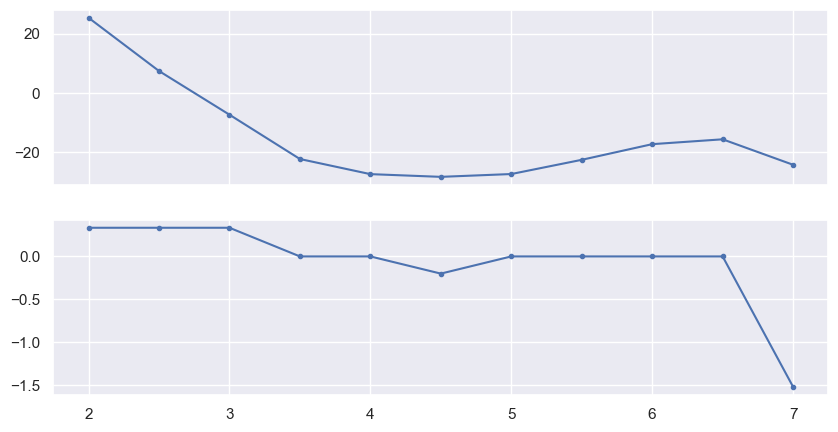

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,5), sharex=True)
live_trade['oas'].plot(marker='.', ax = ax1)
live_trade['weight'].plot(marker='.', ax= ax2)

In [22]:
px.line(OAS[live_trade[weight!=0].index])

## launch samy code

In [28]:
folder = 'DATA_SAMY'

In [29]:
import pandas as pd
import numpy as np
data = pd.read_csv(f'Data/{folder}/mbs_global_data_cleaned_final_2010_2024.csv', index_col=0, parse_dates=True)
data = data.loc[data.index.dropna()]

In [30]:
# from https://www.freddiemac.com/pmms/docs/historicalweeklydata.xlsx
mtg_rate = pd.read_clipboard(index_col=0, parse_dates=True, dayfirst=True)
i1 = list(mtg_rate.index[:2694].map(lambda x : pd.to_datetime(x, format='%d/%m/%Y')))
i2 = list(mtg_rate.index[2694:].map(lambda x : pd.to_datetime(x, format='%m/%d/%Y')))
mtg_rate.index = i1 + i2
dates = pd.date_range(mtg_rate.index.min(), mtg_rate.index.max())
mtg_rate_daily = pd.Series(index=dates, name='mtg_rate')
mtg_rate_daily.loc[mtg_rate.index] = mtg_rate.iloc[:,0]
mtg_rate_daily = mtg_rate_daily.ffill()

ValueError: Neither `start` nor `end` can be NaT

In [ ]:
TBAS_PRICES = pd.read_csv("Data/GENERIC_TBAS.csv", index_col=0, parse_dates=True).dropna(how="all").iloc[:-1]
TBAS_PRICES.columns = TBAS_PRICES.columns.map(lambda x: float(x.split()[1]))
TBAS_PRICES = TBAS_PRICES.loc[:, 2:7]
TBAS_PRICES.columns = TBAS_PRICES.columns.map(lambda x: f'FNCL {x} N Price')

OAS_BLOOM = pd.read_csv("Data/OAS_vs_TREAS.csv", index_col=0, parse_dates=True)
OAS_BLOOM.columns = OAS_BLOOM.columns.map(float)
OAS_BLOOM = OAS_BLOOM.loc[:, 2:7]
OAS_BLOOM.columns = OAS_BLOOM.columns.map(lambda x: f'FNCL {x} N OAS')
OAS_BLOOM.loc[TBAS_PRICES.index[0]: TBAS_PRICES.index[-1]]


vols = pd.read_csv('E:/ehz/data/vol/swaptions_vols.csv', index_col=0, parse_dates=True)
vols = vols.map(lambda x: float(x.replace(',', '.'))).sort_index()
vol = vols['3M10Y'].loc[TBAS_PRICES.index[0]: TBAS_PRICES.index[-1]]/100
vol.name = 'Volatility'

mtg_rate_for_data = mtg_rate_daily.loc[TBAS_PRICES.index[0]: TBAS_PRICES.index[-1]].copy()
mtg_rate_for_data.name = 'Mortgage Rate'

unused = pd.DataFrame(index = TBAS_PRICES.index, columns = ['Coupon effectif', 'Coupon TBA'], dtype=float)

def net_rate(r):
    r_adj = r - 1  # subtract 100 bps
    r_down = (r_adj * 2) // 1 / 2  # round down to nearest 0.5
    return r_down


def calc_loan_age(net_rate_series, target=3.5):
    last_target_date = None
    results = []

    for date, rate in net_rate_series.items():
        if rate == target:
            last_target_date = date

        if last_target_date is None:
            results.append(None)
        else:
            delta_years = (date - last_target_date).days / 365.25  # Account for leap years
            results.append(delta_years)

    return pd.Series(results, index=net_rate_series.index)


net_mtg_rate = mtg_rate_daily.apply(net_rate)

loan_age = pd.concat( [calc_loan_age(net_mtg_rate, target=c) for c in np.arange(2,7.5,0.5)], axis=1)
loan_age.columns = [f'FNCL {c} N Loan Age ' for c in np.arange(2,7.5,0.5) ]
loan_age = loan_age.loc[TBAS_PRICES.index]


zc = pd.read_csv('E:/ehz/data/US_TREAS_CURVE/OTR/discount_factors.csv',index_col=0, parse_dates=True)
zc.columns = zc.columns.map(int)
zc = zc.loc[TBAS_PRICES.index, np.arange(30,11311,30)]
rates = (-np.log(zc)).divide(zc.columns/360)
rates = rates.ffill(axis=1)
zc_interpolated = np.exp(-rates.multiply(zc.columns/360))
zc_interpolated.columns = [f'zc_{x}d' for x in zc.columns]

In [ ]:
raw_data = pd.read_csv(f'Data/DATA_SAMY copy/mbs_global_data_cleaned_final_2010_2024.csv', index_col=0, parse_dates=True)
raw_data = raw_data.loc[raw_data.index.dropna()]

C:\Users\hacen\AppData\Local\Temp\ipykernel_17504\670248641.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  raw_data = pd.read_csv(f'Data/DATA_SAMY copy/mbs_global_data_cleaned_final_2010_2024.csv', index_col=0, parse_dates=True)


In [ ]:
#loan_age = pd.concat( [calc_loan_age(net_mtg_rate, target=c) for c in np.arange(2,7.5,0.5)], axis=1)
loan_age = pd.DataFrame(index=TBAS_PRICES.index, columns=np.arange(2,7.5,0.5), data=0)
loan_age.columns = [f'FNCL {c} N Loan Age ' for c in np.arange(2,7.5,0.5) ]
loan_age = loan_age.loc[TBAS_PRICES.index]

In [ ]:
new_data = pd.concat((
    TBAS_PRICES,
    OAS_BLOOM,
    vol,
    mtg_rate_for_data,
    unused,
    loan_age,
    zc_interpolated
), axis=1)
new_data = new_data.loc[TBAS_PRICES.index]



new_data['Volatility'] = new_data['Volatility'].bfill(axis=0).ffill(axis=0)
new_data['Mortgage Rate'] = new_data['Mortgage Rate'].bfill(axis=0).ffill(axis=0)

In [ ]:
new_data.index.name = 'Dates'
new_data.to_csv(f'Data/{folder}/mbs_global_data_cleaned_final_2010_2024.csv')

In [ ]:
from Optimised_code_upgraded import main

In [ ]:
main(folder)


=== Phase 1: Loading and Processing Data ===

Chargement des données depuis Data\DATA_SAMY\mbs_global_data_cleaned_final_2010_2024.csv...
Période couverte: 2010-01-04 00:00:00 à 2025-04-23 00:00:00
Début du calcul OAS...
Tableau pivoté enregistré dans Data\DATA_SAMY\oas_result_global_2010_2024.csv
OAS calculation completed

=== Phase 2: Initial PnL Calculation ===

=== Phase 3: Performance Analysis ===

=== GLOBAL METRICS ===
----------------------------------------------------------------------------------------------------
Total Return             : 48.1387
Annualized Return        : 3.1798
Annualized Volatility    : 4.0927
Sharpe Ratio             : 0.7769
Sortino Ratio            : 1.0849
Maximum Drawdown         : -6.6277
Hit Ratio                : 0.5141
Average Daily P&L        : 0.0126
Max Daily Gain           : 3.2638
Max Daily Loss           : -1.8638
Trading Days             : 3,826.0000
Gain/Loss Ratio          : 1.1018
Skewness                 : nan
Kurtosis              

In [ ]:
df = pd.read_csv(f'Data/{folder}/oas_result_global_2010_2024_with_pnl.csv', index_col=0, parse_dates=True)
ALL_CPNS = np.arange(2, 7.5, 0.5)

OAS = df[['OAS_0.020', 'OAS_0.025',
       'OAS_0.030', 'OAS_0.035', 'OAS_0.040', 'OAS_0.045', 'OAS_0.050',
       'OAS_0.055', 'OAS_0.060', 'OAS_0.065', 'OAS_0.070']]

OAS.columns = ALL_CPNS

Durations = df[['Duration_0.020',
       'Duration_0.025', 'Duration_0.030', 'Duration_0.035', 'Duration_0.040',
       'Duration_0.045', 'Duration_0.050', 'Duration_0.055', 'Duration_0.060',
       'Duration_0.065', 'Duration_0.070']]
Durations.columns= ALL_CPNS

OAS.to_csv(f'Data/{folder}/OAS.csv')
Durations.to_csv(f"Data/{folder}/Durations.csv")

In [ ]:
data = pd.read_csv(f'Data/{folder}/mbs_global_data_cleaned_final_2010_2024.csv', index_col=0, parse_dates=True)
data = data.loc[data.index.dropna()]
data[data.columns[data.columns.map(lambda x: x.split(' ')[-1] == 'Price')]].to_csv(f"Data/{folder}/GENERIC_TBAS.csv")

## end